In [18]:
import jax
from jax import numpy as jnp
from jax import vmap, jit, grad, jacrev, jacfwd
import matplotlib.pyplot as plt

Vi börjar med att parameterisera en domän, det vill säga ge en <b>periodisk</b> funktion $r\colon[0,2\pi]\to\mathbb{R}^2$ Eftersom vi har mer än en output så måste vi använda ``jacrev`` istället för ``grad`` för att beräkna derivatan $\frac{\mathrm{d}r}{\mathrm{d}t}$. När man har komponenterna $\dot r_x och \dot r_y$ av derivatan så kan man hitta normalvektorn till randen i punkten $(r_x(t), r_y(t))$ som $(\dot r_y(t), -\dot r_x(t))$

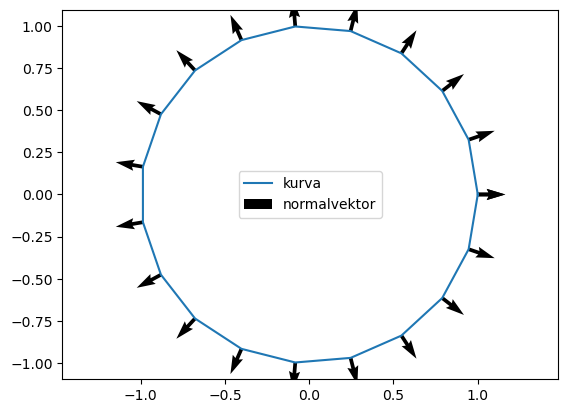

In [27]:
r = lambda t: (jnp.cos(t), jnp.sin(t)) # En cirkel


t = jnp.linspace(0, 2 * jnp.pi, 20) # 20 punkter på cirkeln
(rx, ry) = vmap(r)(t)               # Punkterna på cirkeln
(drx, dry) = vmap(jacrev(r))(t)     # Derivatan av cirkelns parametrisering


# Plotta
plt.plot(rx, ry, label="kurva")
plt.quiver(rx, ry, dry, -drx, label="normalvektor")
plt.axis('equal')
plt.legend()


Nu frågar vi oss, hur kan vi lösa en PDE innanför en kurva? Till exempel, låt oss lösa Poissons ekvation:
$$
    \Delta u(x) = 0, \quad x \;\text{innanför}\quad r
$$
Med randvillkor
$$
    u(x) = g(x),\quad x\;\text{på}\quad r.
$$
Från inlämningsuppgiften jag skickade till er, kan man kanske komma ihåg att $u$ kan lösas som en randintegralekvation. Nämligen, $u$ kan uttryckas som en integral:
$$
    u(x) = \int_r \mu(y)\nabla\log(\|x-y\|)\cdot \hat n(y)\|\mathrm{d}y\|
$$
Där $n(y)$ är normalvektorn på randen $r$ och $\mu(y)$ är en <b>densitet</b> som man kan få fram genom att lösa ekvationssystemet:
$$
    \frac{1}{2}\mu(x) + \frac{1}{2\pi}\int_r \mu(y)\nabla\log(\|x-y\|)\cdot \hat n(y)\|\mathrm{d}y\| = g(x).
$$
Vi vill lösa detta ekvationssystem med jax! Om man skriver om uttrycket ovan med hjälp av parametriseringen $r(t)$ får man, om man definierar $\tilde \mu(t) = \mu(r(t))$, att
$$
    \frac{1}{2}\tilde\mu(t) + \frac{1}{2\pi}\int_0^{2\pi}\tilde\mu(s)\frac{\det([r(s)-r(t), r'(s)])}{\|r(s)-r(t)\|^2}\mathrm{d}s = \tilde g(t).
$$
Vi kan skriva uttrycket ovan mer kortfattat som
$$
    \mu = (\tfrac{1}{2}I + A_r)^{-1}g, \qquad u = B_r\mu,\qquad \text{eller}\qquad u = B_r(\tfrac{1}{2}I + A_r)^{-1}g
$$
Där $A_r$ och $B_r$ är integraloperatorer, som beror på $r$. Säg att vi nu vill minimera medelvärdet $\int_\ell u(x)\mathrm{d}x$ av $u$ över någon linje $\ell$. Då Kan man se det som att $u$ är en funktion av $r$:
$$
    r \mapsto \int_\ell u \quad \text{eftersom}\quad r\mapsto (A_r, B_r)\mapsto B_r(\tfrac{1}{2}I + A_r)^{-1}g = u\mapsto \int_\ell u.
$$
För att kunna derivera $\int_\ell u$ med avseende på $r$, vill vi implementera alla avbildningarna ovanför i ``jax``. Det svåraste kommer nog att vara inversen $(\dots)^{-1}$. Det intressanta är att vi kan nöja oss med att implementera bara <b>verkan</b> av operatorerna $A_r$ och $B_r$. Det vill säga, givet $r$ och en funktion $h$, så vill vi implementera $(r, h)\mapsto A_r h$ och $(r, h)\mapsto B_r h$ som funktioner i ``jax``.

In [53]:

def A(r, h):
    """Givet h och r, båda på randen, beräkna randintegralen 
    $$
        1/(2pi) * \integ{0->2pi} h(s) * det([r(s)-r(t), r'(s)]) / ||r(s)-r(t)||^2 ds
    $$
    Kräver att hantera fallet då s=t separat, eftersom det annars blir avrundningsfel pga division med 0.
    """
    pass

r_ab = lambda a,b: lambda t: (a * jnp.cos(t), b * jnp.sin(t)) # En cirkel

def sub(a, b):
    return (a[0]-b[0], a[1]-b[1])

def det(a, b):
    return a[0]*b[1] - a[1]*b[0]

def norm2(a):
    return a[0]**2 + a[1]**2

def kern_pv(r, s, t):
    delta_r = sub(r(s), r(t))
    return det(delta_r, jacrev(r)(s)) / norm2(delta_r)

def kern(r, s, x):
    delta_r = sub(r(s), x)
    return det(delta_r, jacrev(r)(s)) / norm2(delta_r)

def integrate(r, h, x):
    t = jnp.linspace(0, 2 * jnp.pi, 201)[:-1] # 200 punkter på cirkeln (sista punkten är samma som första)
    integrand = lambda t: h(t) * kern(r, t, x)
    return jnp.sum(vmap(integrand)(t)) / (2 * jnp.pi)
    

f = lambda a,b: integrate(r_ab(a, b), lambda t: 1, (0.,0.))
grad(f, argnums=(0, 1))(1., 1.)

# Redan ett sätt att integrera över en ellips och derivera med avseende på axlarna!


(Array(-1.9073486e-06, dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))